# 主題：電影上映初期評分 VS 長期評分

--------

`(海水有退的話)海水退了就知道誰沒穿褲子，那怎麼樣的情況才會海水退掉？`


>IMDb有設立一個「TOP 250」（史上250大佳片）的排行榜，不少電影愛好者，想看過往未看的佳片，都會不時來逛逛。...這幾年台灣的片商、代理商，為了宣傳，只要美國先上映推出，台灣較晚上映的電影，如果該電影在IMDb和爛番茄上評價高分，都會被用來當數據行銷。([IMDb如何告訴你電影好不好看？](https://edwardmovieclub.com/imdb%E5%A6%82%E4%BD%95%E5%91%8A%E8%A8%B4%E4%BD%A0%E9%9B%BB%E5%BD%B1%E5%A5%BD%E4%B8%8D%E5%A5%BD%E7%9C%8B%EF%BC%9F/))

許多人進戲院、租借片子前，會先看電影評分才決定要不要觀看，想當然爾地吸引片商或相關利益團體，在電影上映初期，進攻討論看板和電影評分網以的營造熱度。刻意營造風向熱度當然不是好事，過去討論多集中在辨認假帳號，例如：[Re: \[討論\] 說52沒有工讀生帶風向...我不相信!](https://www.ptt.cc/bbs/movie/M.1485513866.A.728.html)
，以分析異常的個別使用者評分來屏蔽假帳號，例如評分次數、發表評分時間等等。

但道高一尺魔高一丈，片商隨時都能雇用工讀生辦假帳號洗評分，或是購買已經使用多年的帳號來騙過這樣的判斷規則。本次分析改嘗試以電影本身的角度切入，**我們定義「發行初期」為電影發行後的14天內，觀察發行初期評分和發行初期過後評分分佈有所差異的電影，究竟怎樣的電影比較可能出現評分分佈不同？**

### 分析目標：以電影基本資料(類型、發行公司等)，預測其發行14天內和其後的評分分佈是否不同


# Contents
-----
- Data Preprocessing
    - 使用資料來源介紹
    - 整理出個別電影的基本資料
    - 整理評分資料，定義分類目標
    - 整理出建模用資料表
- EDA
- Modeling & Insights

In [1]:
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', 40)
from datetime import datetime
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Data Preprocessing
------
## 使用資料來源介紹
- [MovieLens 20M Dataset](https://grouplens.org/datasets/movielens/20m/):內含14萬使用者於2.7萬部電影的評分與貼標，共2000萬評分人次，詳細內容如 Readme。
- [TMDB API](https://www.themoviedb.org/documentation/api):由於 MovieLens 資料集僅記載各電影發行年份，若要分析發行初期的評價和初期過後的評價行為，我從 TMDB 下載確切的電影發行日期，也順便抓取其他電影相關資料，包含電影的發行國家、公司、預算，猜想他們可能是潛在影響發行初期與初期過後評價不同的因素。


## 整理出個別電影的基本資料
- step1 使用 TMDB API 下載電影的發行日期、預算、電影公司、國家，存為`movie_meta_from_TMDB.csv`
- step2 `movies.csv`中紀錄個別電影的名稱、類別，將兩個資料表 inner join命名為`movie_meta.csv`
- step3 放棄在TMDB未記載發行日期的電影
- step4 篩選發行期間為1998~2015的電影 (根據維基百科 MovieLens 1997 年才上線，早於此日期發行的電影資料內便沒有記載發行初期的評分行為；相反地資料集只記載到2015年的使用者評分，2015之後發行的電影沒有記載發行期過後的長期評分行為)

In [2]:
def getDetailFromTMDB(tmdbid):
    import http.client
    import json
    Api_key = '6b8989c6a1cd059cab1c483679040253'
    conn.request("GET", "/3/movie/"+str(int(tmdbid))+"?language=en-US&"+"api_key="+Api_key, payload)
    res = conn.getresponse()
    data = res.read().decode("utf-8")
    js = json.loads(data)
    try:
        company = js['production_companies'][0]['name']
    except:
        company = None
    try:
        country = js['production_countries'][0]['iso_3166_1']
    except:
        country = None
    try:
        title = js['title']
    except:
        title = None
    try:
        budget = js['budget']
    except:
        budget = None
    try:
        release_date = js['release_date']
    except:
        release_date = None
    return pd.Series({'tmdbId':tmdbid,'title':title,'company':company,'country':country,'budget':budget,'release_date':release_date})

In [271]:
#step1 Fetch movie meta data from TMDB (100 movies/batch) and write to movie_meta_from_TMDB.csv
link = pd.read_csv("./links.csv")
link = link[link['tmdbId'].notnull()]
for i in range(0,len(link),100):
    conn = http.client.HTTPSConnection("api.themoviedb.org")
    payload = "{}"
    movie_meta_from_TMDB = link['tmdbId'][i:i+100].apply(getDetailFromTMDB)
    with open('movie_meta_from_TMDB.csv', 'a') as f:
        movie_meta_from_TMDB.to_csv(f, header=False)

In [4]:
# One hot encode genres data for each movie from movies.csv
movies = pd.read_csv("./movies.csv")
genres_list = ['Action','Adventure','Animation','Children','Comedy','Crime','Documentary','Drama',
                'Fantasy','Film-Noir','Horror','Musical','Mystery','Romance','Sci-Fi','Thriller',
                'War','Western']
movies = pd.concat([movies, movies['genres'].apply(lambda x: pd.Series([i in x for i in genres_list],index=genres_list))], axis=1)

In [5]:
#step2 Merge meta data from TMDB
movie_meta = pd.read_csv("./movie_meta_from_TMDB.csv",names=['tmdbId','title','company','country','budget','release_date'],encoding='utf-8')
movie_meta = pd.merge(link,movie_meta,on='tmdbId',how='inner')
movie_meta = pd.merge(movie_meta,movies.drop(['title','genres'],axis = 1),on='movieId',how='inner')
movie_meta.drop(['imdbId','tmdbId'],axis = 1,inplace=True)
movie_meta['release_date']=pd.to_datetime(movie_meta['release_date'])

In [6]:
#step3 Drop rows that has no data in tmdb
movie_meta = movie_meta[movie_meta['title'].notnull()] 
movie_meta = movie_meta[movie_meta['release_date'].notnull()] 
#step4 Exclude the records with (1)movie released before movielens went online(1997) (2)released at the end of data collecting
movie_meta = movie_meta[movie_meta['release_date'].apply(lambda x:x.year>=1998 and x.year<2015)]

In [8]:
movie_meta.head()
movie_meta.to_csv("movie_meta.csv",index = False)

## 整理評分資料，定義分類目標
- step 1 `ratings.csv` 記錄各使用者對各電影的評分及其評分時間。對照前面整理好的`movie_meta.csv`中的發行時間，計算出各次評分晚於電影發行日多少天。
- step 2 我們定義發行後14天內為發行初期，將資料拆成「各電影於發行初期的評分」和「各電影於發行初期過後的評分」兩部份
- step 3 篩選出兩部份皆有達 30個評論數的電影
- step 4 檢定發現多數電影的評分資料非常態分佈，因此**以 Mann–Whitney U test 檢定發行初期和發行初期過後的評分分佈是否相同，作為本次的分類目標**

In [25]:
ratings = pd.read_csv("./ratings.csv")
movie_meta = pd.read_csv("./movie_meta.csv")

In [26]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,2,3.500,1112486027
1,1,29,3.500,1112484676
2,1,32,3.500,1112484819
3,1,47,3.500,1112484727
4,1,50,3.500,1112484580


In [27]:
# step1
ratings['rating_date'] = pd.to_datetime(ratings['timestamp'], unit='s').dt.floor('d')
ratings = pd.merge(ratings,movie_meta.loc[:,['movieId','release_date']],how = 'inner',on = 'movieId')
ratings['release_date'] = pd.to_datetime(ratings['release_date'])
ratings.drop(['timestamp'],axis = 1,inplace = True)
ratings['days_rating_time_from_release'] = (ratings['rating_date'] - ratings['release_date']).apply(lambda x:x.days)
#ratings.to_csv('ratings_with_release_date.csv',index = False)

In [28]:
# step2
compaign_period = 14
campaign_rating = ratings[ratings['days_rating_time_from_release']<=compaign_period ]
aftercampaign_rating = ratings[ratings['days_rating_time_from_release']>compaign_period ]

In [29]:
# step3
enough_rating_number = 30
movie_rating_count = pd.merge(pd.DataFrame(campaign_rating.groupby('movieId')['userId'].count()),pd.DataFrame(aftercampaign_rating.groupby('movieId')['userId'].count()), left_index=True, right_index=True)
movieId_list_enough_rating = movie_rating_count[(movie_rating_count['userId_x']>enough_rating_number) & (movie_rating_count['userId_y']>enough_rating_number)].index.values

In [30]:
# testing functions that used instep4
def same_var_test(x,y):
    #https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.levene.html
    # levene is from not normal dist
    # H0: same var
    from scipy.stats import levene
    stat, p = levene(x,y)
    alpha = 0.05
    if p < alpha:
        return False
    else:
        return True    
def normality_test(data):
    #https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html
    # H0: normal
    from scipy.stats import normaltest
    stat, p = normaltest(data)
    alpha = 0.05
    if p < alpha:
        return False
    else:
        return True
def same_dist_test(x,y):
    #Mann–Whitney U test: test whether not normal samples from same distribution
    # H0: sample dist
    #https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test
    #https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html#scipy.stats.mannwhitneyu
    from scipy.stats import mannwhitneyu
    stat, p = mannwhitneyu(x,y)
    alpha = 0.05
    if p < alpha:
        return False
    else:
        return True

In [31]:
# step4
test_result = pd.DataFrame(movieId_list_enough_rating,columns=['movieId'])
test_result['total_normality'] = [normality_test(ratings[ratings['movieId']==i]['rating']) for i in movieId_list_enough_rating]
test_result['campaign_normality'] = [normality_test(campaign_rating[campaign_rating['movieId']==i]['rating']) for i in movieId_list_enough_rating]
test_result['aftercampaign_normality'] = [normality_test(aftercampaign_rating[aftercampaign_rating['movieId']==i]['rating']) for i in movieId_list_enough_rating]
test_result['equalvar'] = [same_var_test(campaign_rating[campaign_rating['movieId']==i]['rating'],aftercampaign_rating[aftercampaign_rating['movieId']==i]['rating']) for i in movieId_list_enough_rating]
test_result['same_dist'] = [same_dist_test(campaign_rating[campaign_rating['movieId']==i]['rating'],aftercampaign_rating[aftercampaign_rating['movieId']==i]['rating']) for i in movieId_list_enough_rating]

In [32]:
test_result.head()
test_result.to_csv("./test_result.csv")

## 整理出建模用資料表
- step1 將`movie_meta.csv`和`test_result.csv`結合，我們的目標就是以電影的基本資料來嘗試分類`same_dist`
- step2 將發行日期的發行年份、月份抽出為分析變數。
- step3 依照過往[影評分析經驗](https://www.quora.com/What-are-considered-the-peak-seasons-for-movie-releases-in-theaters)，每年電影有兩個熱期，分別是針對奧斯卡頒獎的年底三個月和暑假初期的7月，所以我們製造`oscar_season`和`blockbuster_season`兩個變數

In [33]:
# step1
movie_meta = pd.read_csv("./movie_meta.csv")
test_result = pd.read_csv("./test_result.csv")
movie_final = pd.merge(movie_meta,test_result.loc[:,['movieId','same_dist']],how='inner',on= 'movieId')

In [34]:
# step2
movie_final['release_date'] = pd.to_datetime(movie_final['release_date'])
movie_final['release_year'] = movie_final['release_date'].apply(lambda x: x.year)
movie_final['release_month'] = movie_final['release_date'].apply(lambda x: x.month)
movie_final['blockbuster_season'] = movie_final['release_date'].apply(lambda x: x.month in [7])
# step3
movie_final['oscar_season'] = movie_final['release_date'].apply(lambda x: x.month in [10,11,12])
movie_final = movie_final.drop(['movieId','title','release_date'],axis = 1)

In [35]:
movie_final.head()

,company,country,budget,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,same_dist,release_year,release_month,blockbuster_season,oscar_season
0,Paramount,US,60000000.000,False,False,False,False,True,False,False,True,False,False,False,False,False,False,True,False,False,False,True,1998,6,False,False
1,Touchstone Pictures,US,140000000.000,True,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,False,False,False,1998,7,True,False
2,Silver Pictures,US,140000000.000,True,False,False,False,True,True,False,False,False,False,False,False,False,False,False,True,False,False,False,1998,7,True,False
3,Amblin Entertainment,US,40000000.000,False,False,True,True,False,False,False,False,True,False,False,False,False,False,False,False,True,False,True,1998,7,True,False
4,20th Century Fox,US,23000000.000,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,1998,7,True,False


# EDA
避免太多圖片佔版面，這裡以文字敘述為主，僅放置幾個重要的圖表
- 分類目標`same_dist`：兩個類別的數量還算平均{0:355, 1:266}
- (Fig1)評分在發行初期和發行初期過後分佈不同，以 Star Wars: Episode I - The Phantom Menace 為例：發行初期高分明顯較多，初期過後則成類似鍾型分佈
- (Fig2)評分在發行初期和發行初期過後分佈相似，以 The Truman Show 為例：發行初期和初期過後低分都很少，高分部分把初期過後的.5部分疊加起來可以發現分佈是相似的
- (Fig3)目標變數和發行年份也有關，2007年以後的電影發行初期和發行初期過後的評分分佈相似的比例明顯升高
- 單一個別電影類型和目標變數無明顯關係
- 月份和目標變數有點關係，但我們生成的`oscar_season`和`blockbuster_season`和目標變數無明顯關係

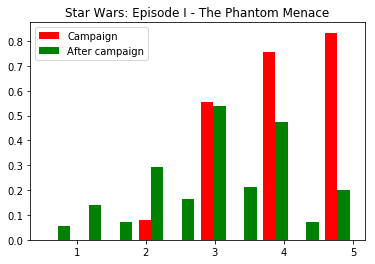

In [36]:
# Fig1 same_dist = False
plt.hist([campaign_rating[campaign_rating['movieId']==2628]['rating'],aftercampaign_rating[aftercampaign_rating['movieId']==2628]['rating']],color = ['red','green'],normed=True)
plt.title("Star Wars: Episode I - The Phantom Menace")
plt.legend(["Campaign","After campaign"])

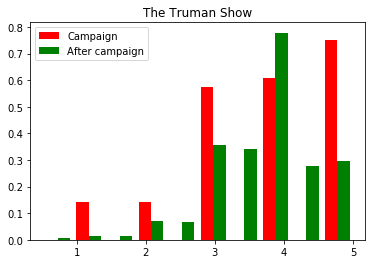

In [37]:
# Fig2 same_dist = True
plt.hist([campaign_rating[campaign_rating['movieId']==1682]['rating'],aftercampaign_rating[aftercampaign_rating['movieId']==1682]['rating']],color = ['red','green'],normed=True)
plt.title("The Truman Show")
plt.legend(["Campaign","After campaign"])


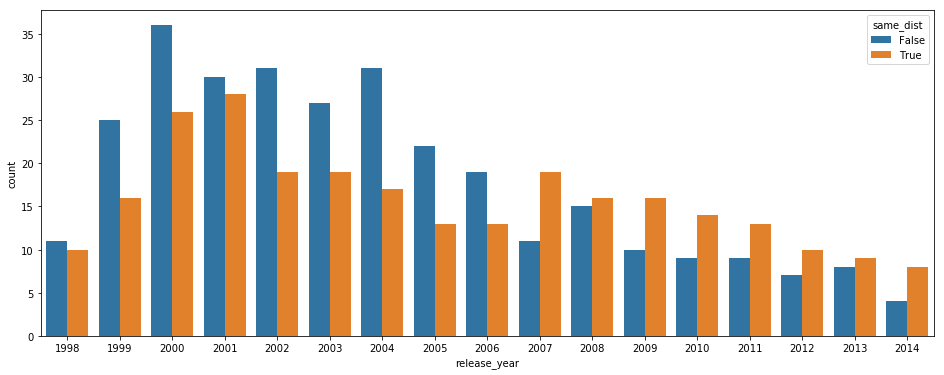

In [38]:
# Fig 3 Target - release_year
plt.figure(figsize=(16, 6))
sns.countplot(x = 'release_year',hue='same_dist',data = movie_final)

# Modeling & Insights
-------
以 RandomForest 和 XGBoost 建模，嘗試各種參數組合
- 電影公司、預算、發行年份和月份為較重要的變數，電影類型預測能力不佳
- 模型準確率(0.7)比亂猜準確率(0.55)好一些
- Confusion matrix 顯示模型比較擅於辨認不相似的分數分佈，正好符合本次分析目標主要關注怎樣的電影會有分數分佈不相似的情形。
- Discussion:預測變數不應該放發行年份？新的電影的發行年不可能是過去的年份，因此用年份建出來的模型沒辦法實際應用在日後新發行的電影，我認同有這樣的疑慮，不過有些電影係屬重製、重拍，所以登記的(原版)發行年也可能是過去年份，例如星際大戰、一個巨星的誕生，依此想法可將發行年份結合其他資訊轉換新的變數，或由使用者貼標資料來補足。
- Future Work:本次分析因時間因素，沒做到使用者貼標資料，「貼標數量」、「貼標內容」、「貼標時間」、「各標籤重要度」也可能有助於本次的分析需求

In [47]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report,confusion_matrix

In [48]:
for col in [i for i in movie_final.columns if i not in ['budget','release_year','release_month']]:
    movie_final[col] = LabelEncoder().fit_transform(movie_final[col].fillna('None'))
x = movie_final.drop(['same_dist'],axis = 1)
y = movie_final['same_dist']
x_train, x_test, y_train, y_test = train_test_split(x,y , test_size=0.1)

In [49]:
# RandomForest
from sklearn.ensemble import RandomForestClassifier
params = {'n_estimators':[5,10,100,300,500,800],'max_depth':[2,3,4]}
grid = GridSearchCV(RandomForestClassifier(),params,refit=True,verbose=1,error_score='f1')
grid.fit(x_train,y_train)
print(grid.best_params_)
rf_grid_predictions = grid.predict(x_test)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
{'max_depth': 2, 'n_estimators': 10}


[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:   26.7s finished


In [50]:
print(classification_report(y_test,rf_grid_predictions))
print("Acc = "+str(sum(y_test==rf_grid_predictions)/len(y_test)))

             precision    recall  f1-score   support

          0       0.65      0.88      0.75        32
          1       0.73      0.42      0.54        26

avg / total       0.69      0.67      0.65        58

Acc = 0.6724137931034483


In [51]:
print("feature_importances_")
pd.DataFrame([list(x.columns),list(grid.best_estimator_.feature_importances_)])

feature_importances_


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,company,country,budget,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,release_year,release_month,blockbuster_season,oscar_season
1,0.000,0.045,0.227,0.000,0.000,0.000,0.000,0.015,0.042,0.000,0.016,0.000,0.045,0.013,0.000,0.000,0.000,0.000,0.007,0.048,0.037,0.280,0.165,0.000,0.061


In [52]:
# xgboost
from xgboost import XGBClassifier
params = {'n_estimators': [50, 100, 200],'max_depth': [2,3,4],'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3]}

grid = GridSearchCV(XGBClassifier(),params,refit=True,verbose=1,error_score='f1')
grid.fit(x_train,y_train)
print(grid.best_params_) 
xgb_grid_predictions = grid.predict(x_test)

Fitting 3 folds for each of 45 candidates, totalling 135 fits
{'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100}


[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed:    8.0s finished


In [53]:
print(classification_report(y_test,xgb_grid_predictions))
print("Acc = "+str(sum(y_test==xgb_grid_predictions)/len(y_test)))

             precision    recall  f1-score   support

          0       0.57      0.72      0.64        32
          1       0.50      0.35      0.41        26

avg / total       0.54      0.55      0.54        58

Acc = 0.5517241379310345


In [54]:
print("feature_importances_")
pd.DataFrame([list(x.columns),list(grid.best_estimator_.feature_importances_)])

feature_importances_


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,company,country,budget,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,release_year,release_month,blockbuster_season,oscar_season
1,0.271,0.061,0.221,0.024,0.021,0.016,0.013,0.018,0.006,0.000,0.026,0.005,0.000,0.006,0.000,0.019,0.014,0.024,0.019,0.002,0.005,0.122,0.098,0.008,0.000
